# Tarea 4 - Machine Learning - SVM & MNIST

Using Support Vector Machine to solve the MNIST handwritten digit problem.

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.spatial import distance_matrix
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm) # dont print the numpy version of the confusion matrix

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [3]:
# cargar dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
print("Shape data", X.shape)
print("Label", y.shape)

Shape data (70000, 784)
Label (70000,)


Change the type str into int of the labels.

In [5]:
# assert(type(y[0]) == str) is True
y = y.astype(int) # change as type numpy.int64

In [6]:
# split the dataset for the study / random state we control the random IT IS REPETABLE
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=2/7, shuffle=True, random_state=40)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=1/2, shuffle=True, random_state=23)

In [7]:
print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)
print("Validation dataset:", X_val.shape, y_val.shape)

Train dataset: (50000, 784) (50000,)
Test dataset: (10000, 784) (10000,)
Validation dataset: (10000, 784) (10000,)


Standardize the data using the information in the training dataset.
Standardization is done using this formula (on each each feature column) : $\tilde{X} = \dfrac{X-\mu}{\sigma}$

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Data visualization

First we want to check if the images correspond to their labels. So are going to check it quickly using a simple random visualization function.

In [9]:
def visualize_random_imgs(nb_imgs=1):
    """
        Function used to visualize random images with their associated labels from the training set.
        
        Arguments:
            nb_imgs (int) : Number of images to visualize. Default to one.
        
        Display images does not return anything.
    """
    random_idx = np.random.randint(len(X_train), size=nb_imgs)
    for idx in random_idx:
        print("Index :", idx)
        features, label = X_train[idx, :], y_train[idx]
        # need to inverse transform to make the image clean
        features = scaler.inverse_transform(features)
        reshaped_features = np.reshape(features, (28,28))
        print("Label :", label)
        plt.imshow(reshaped_features, cmap="gray")
        plt.show()

Index : 49457
Label : 8


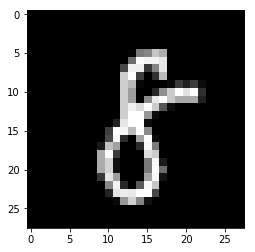

In [10]:
visualize_random_imgs()

We are going to visualize the data in a 2D-humanly visuable space using a PCA projection.

In [13]:
def pca_visualization(labels_showed=np.linspace(0, 9, 10), k=100):
    """
        Function used to project training dataset in a 2D space.
        
        Arguments:
            labels_showed (array) : array of values in [0, 9].
            k (int) : number of elements display per class.
        
    """
    # PCA step
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    
    # visual step
    fig, ax = plt.subplots()
    for g in np.unique(y_train):
        if g in labels_showed:
            i = np.where(y_train == g)
            x_coord, y_coord = X_train_pca[i ,0].T[:k], X_train_pca[i ,1].T[:k]
            ax.scatter(x_coord, y_coord, label=g)
    ax.legend()
    plt.xlabel("pc1")
    plt.ylabel("pc2")
    plt.title("Handwritten digit in 2D using PCA with associated class")

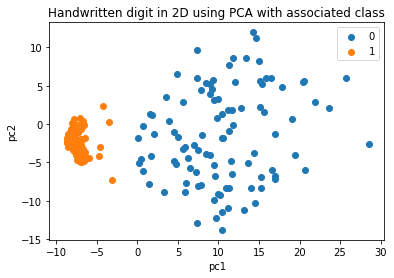

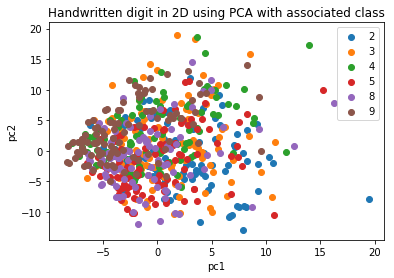

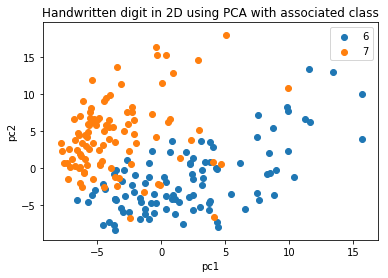

In [24]:
pca_visualization(labels_showed=[1, 0])
pca_visualization(labels_showed=[2, 3, 4, 5, 8, 9])
pca_visualization(labels_showed=[6, 7])

## Kernels

We are going to develop three different kernels that we will use later on in order create our Support Vector Machine model. Linear, Gaussian and Polynomial.

Links :
http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/

https://scikit-learn.org/stable/modules/svm.html#svm-kernels

https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html

In [16]:
# MADE BY HAND KERNEL VERSIONS
def my_rbf_kernel(X, Y, sigma=1/784):
    return np.exp(-sklearn.metrics.pairwise.euclidean_distances(X, Y, squared=True)*sigma)
    
def my_linear_kernel(X, Y, c=0):
    return np.dot(X, Y.T) + c
    
def my_poly_kernel(X, Y, alpha=1, c=1, d=3):
    return (alpha*np.dot(X, Y.T) + c)**d

# SKLEARN KERNEL VERSION => MUCH MUCH MUCH FASTER
def opt_rbf_kernel(X, Y, sigma=1/784):
    # sigma default = 1 / number of features
    return sklearn.metrics.pairwise.rbf_kernel(X, Y, gamma=sigma)

def opt_linear_kernel(X, Y, c=0):
    return sklearn.metrics.pairwise.linear_kernel(X, Y)
    
def opt_poly_kernel(X, Y, alpha=1, c=1, d=3):
    return sklearn.metrics.pairwise.polynomial_kernel(X, Y)

## Classification

Now we are going to evaluate our clasification technique with different C values. 
C represents how them SVM model is permissive to data not really perfectly separated.

In [100]:
# PRECOMPUTED KERNEL VERSION
svm_clf = SVC(C=1.0, kernel="precomputed")
k = 1000
print("Precomputing kernel...")
precomputed_kernel = my_rbf_kernel(X_train[:k], X_train[:k])
print("Training...")
svm_clf.fit(precomputed_kernel, y_train[:k])

Precomputing kernel...
Training...


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Technique to use your own kernels but at least the kernel creation is not too long.

In [121]:
# MY OWN KERNEL VERSION
svm_clf = SVC(C=1.0, kernel=opt_linear_kernel)
print("Training...")
k = 16000
svm_clf.fit(X_train[:k], y_train[:k])

Training...


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel=<function opt_linear_kernel at 0x7f5771dfb158>, max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [122]:
y_val_pred = svm_clf.predict(X_val)

In [17]:
def evaluatePred(predictions, true_labels):
    acc = accuracy_score(y_true=true_labels, y_pred=predictions)
    print("Accuracy =", acc)
    plot_confusion_matrix(y_pred=predictions, y_true=true_labels, classes=np.linspace(0, 9, 10, dtype=int))
    return acc

## Finding the best C hyperparameter

Work with the train and validation set in order to find the best C.

Current C= 0.1
Training...
Predict...
Accuracy = 0.9164
Confusion matrix, without normalization


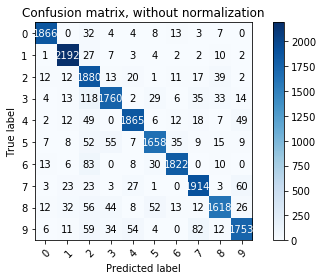

Accuracy = 0.9059
Confusion matrix, without normalization


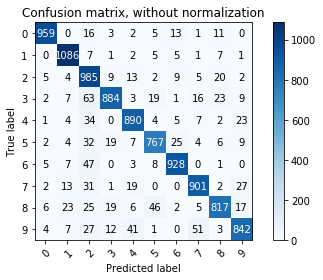

Current C= 0.25
Training...
Predict...
Accuracy = 0.9457
Confusion matrix, without normalization


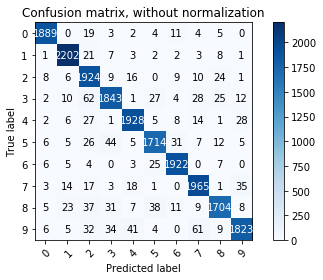

Accuracy = 0.9298
Confusion matrix, without normalization


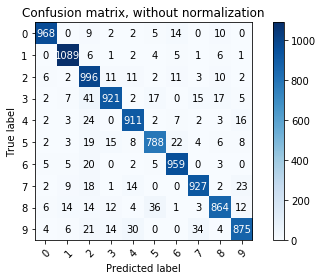

Current C= 0.5
Training...
Predict...
Accuracy = 0.96405
Confusion matrix, without normalization


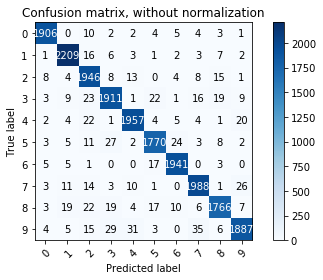

Accuracy = 0.9416
Confusion matrix, without normalization


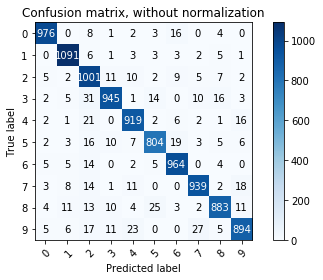

Current C= 0.75
Training...
Predict...
Accuracy = 0.97525
Confusion matrix, without normalization


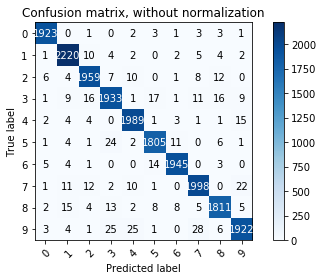

Accuracy = 0.9477
Confusion matrix, without normalization


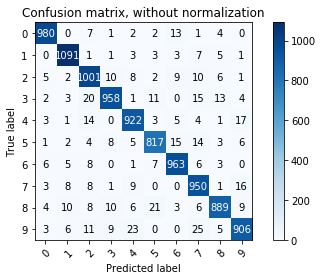

Current C= 1.0
Training...
Predict...
Accuracy = 0.98065
Confusion matrix, without normalization


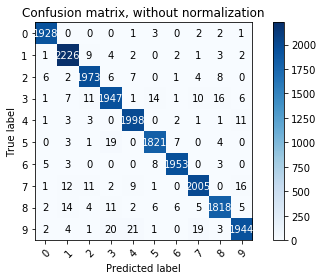

Accuracy = 0.9519
Confusion matrix, without normalization


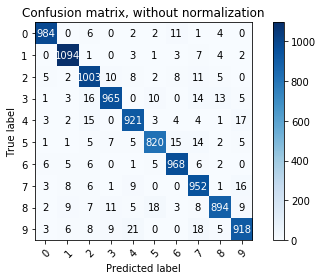

In [21]:
C_to_try = [0.1, 0.25, 0.5, 0.75, 1.0]
k = 20000
stock_acc = np.zeros(shape=(len(C_to_try), 2))
for i, C_value in enumerate(C_to_try):
    # MY OWN KERNEL VERSION
    print("Current C=", C_value)
    svm_clf = SVC(C=C_value, kernel=opt_rbf_kernel)
    print("Training...")
    svm_clf.fit(X_train[:k], y_train[:k])
    print("Predict...")
    y_pred_train = svm_clf.predict(X_train[:k])
    y_pred_val = svm_clf.predict(X_val)
    acc_train = evaluatePred(predictions=y_pred_train, true_labels=y_train[:k])
    acc_validation = evaluatePred(predictions=y_pred_val, true_labels=y_val)
    stock_acc[i] = np.array([acc_train, acc_validation])

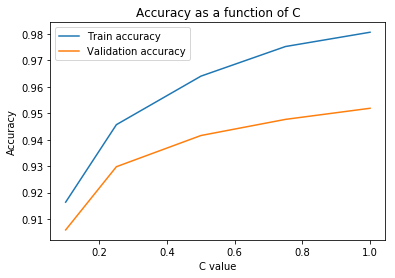

In [24]:
plt.plot(C_to_try, stock_acc[:, 0], label="Train accuracy")
plt.plot(C_to_try, stock_acc[:, 1], label="Validation accuracy")
plt.legend()
plt.title("Accuracy as a function of C")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.show()

Evaluating using the test set with the best C obtained.

## Evaluating different Kernel

Now we are going to evaluate our three kernels : linear, rbf and polynomial considering the best C value found in the previous part.

Training...
Predict...
Accuracy = 0.9511
Confusion matrix, without normalization


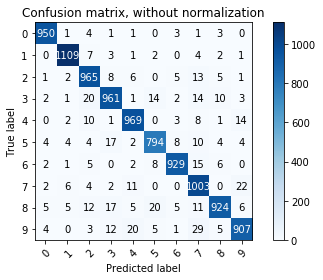

Accuracy = 0.9519
Confusion matrix, without normalization


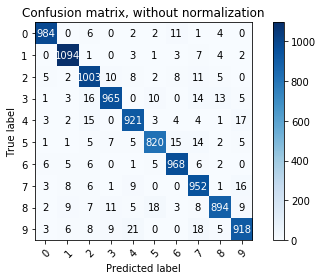

Training...
Predict...
Accuracy = 0.9123
Confusion matrix, without normalization


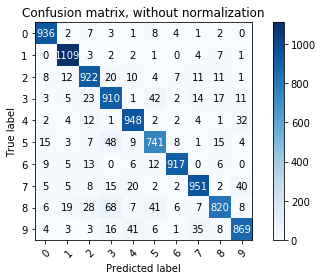

Accuracy = 0.9123
Confusion matrix, without normalization


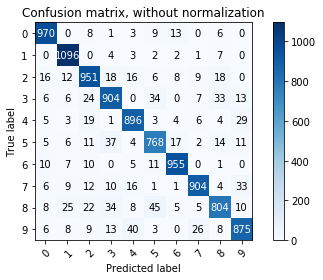

Training...
Predict...
Accuracy = 0.9627
Confusion matrix, without normalization


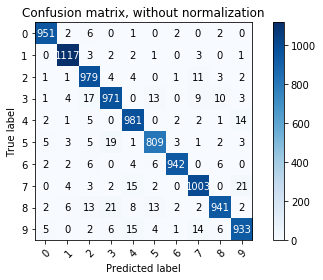

Accuracy = 0.9628
Confusion matrix, without normalization


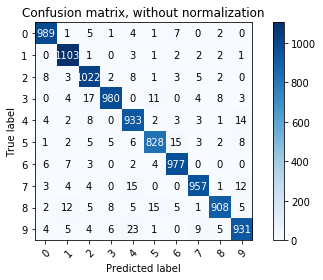

In [26]:
k = 20000
stock_acc2 = np.zeros(shape=(3, 2))
for i, cur_kernel in enumerate([opt_rbf_kernel, opt_linear_kernel, opt_poly_kernel]):
    # MY OWN KERNEL VERSION
    svm_clf = SVC(C=1.0, kernel=cur_kernel)
    print("Training...")
    svm_clf.fit(X_train[:k], y_train[:k])
    print("Predict...")
    y_pred_test = svm_clf.predict(X_test)
    y_pred_val = svm_clf.predict(X_val)
    acc_test = evaluatePred(predictions=y_pred_test, true_labels=y_test)
    acc_validation = evaluatePred(predictions=y_pred_val, true_labels=y_val)
    stock_acc2[i] = np.array([acc_test, acc_validation])

In [29]:
print(list(stock_acc2))

[array([0.9511, 0.9519]), array([0.9123, 0.9123]), array([0.9627, 0.9628])]
